In [ ]:
import os
import docvision as dv
import docgenpipe as dg
import docdataset as dd

/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
cd ..

/Users/asukh/Work/VSCode/Python/ucu-mt


/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
cd /root/ucu-mt

[Errno 2] No such file or directory: '/root/ucu-mt'
/Users/asukh/Work/VSCode/Python/ucu-mt/src


/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [10]:
dataset = dd.download_dataset()['train']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

def analyze_grounding_word_counts_from_dataset(dataset: list[dict], count_mode: str = "word"):
    """
    Aggregates and returns total word or character counts from all 'text' grounding entries per document.

    Args:
        dataset (list[dict]): The input dataset.
        count_mode (str): "word" to count words, "char" to count characters (default: "word").

    Returns:
        pd.DataFrame: Aggregated count statistics per document.
    """
    assert count_mode in ["word", "char"], "count_mode must be 'word' or 'char'"

    doc_texts = defaultdict(str)
    meta = {}


    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")
        meta[doc_id] = {"category": category, "style": style}
        for g in row.get("grounding", []):
            if g.get("type") == "text":
                doc_texts[doc_id] += " " + g.get("content", "")


    records = []
    for doc_id, full_text in doc_texts.items():
        if count_mode == "word":
            count = len(re.findall(r'\w+', full_text, re.UNICODE))
        else: 
            count = len(full_text)

        records.append({
            "doc_id": doc_id,
            "category": meta[doc_id]["category"],
            "style": meta[doc_id]["style"],
            "count": count
        })

    df = pd.DataFrame(records)

    agg_df = df.groupby(['doc_id', 'category', 'style'])['count'].agg(['min', 'max', 'mean']).reset_index()

    return agg_df


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_word_counts(agg_df, count_mode):
    """
    Creates a single boxplot for word count distribution:
    - Overall word count per document
    - Per style (print, hand, scan)
    """
    sns.set_theme(style="white")

    plt.figure(figsize=(10, 6))

    overall_df = agg_df.copy()
    overall_df["style"] = "overall"
    combined_df = pd.concat([agg_df, overall_df], ignore_index=True)

    palette = sns.blend_palette(["#a5d6a7", "#ce93d8"], n_colors=4)

    sns.boxplot(data=combined_df, x="style", y="mean", palette=palette)

    plt.xlabel("")
    plt.ylabel(f"{count_mode} Count", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.grid(False)
    sns.despine(top=True, right=True)

    plt.show()

/var/folders/yr/4p_vsm354x598ht21719ydj80000gq/T/ipykernel_72886/818014638.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="style", y="mean", palette=palette)


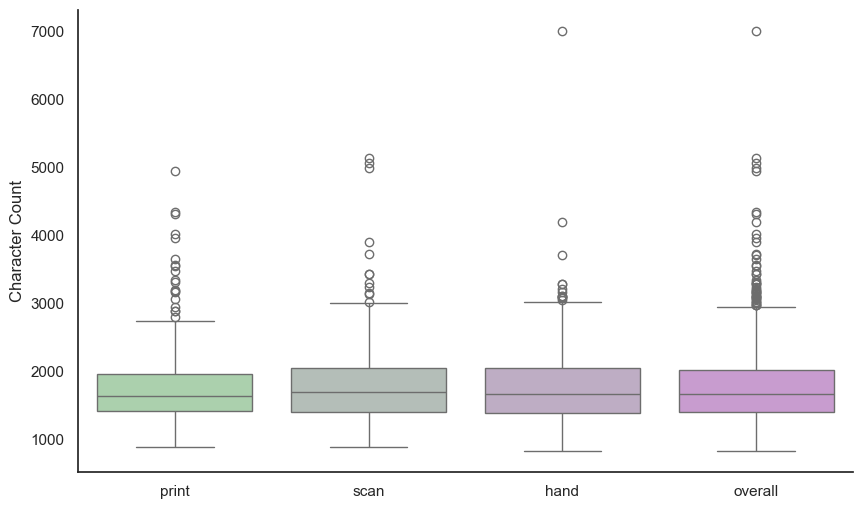

In [37]:
stats_df = analyze_grounding_word_counts_from_dataset(dataset, count_mode="char")
plot_combined_word_counts(stats_df, count_mode="Character")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict


def extract_word_counts(dataset: list[dict], count_mode: str = "word"):
    """
    Extracts word or character counts from all 'text' grounding entries per document.

    Args:
        dataset (list[dict]): Input dataset with grounding entries.
        count_mode (str): "word" to count words, "char" to count characters.

    Returns:
        pd.DataFrame: Document-level rows with count, category, and style.
    """
    assert count_mode in ["word", "char"], "count_mode must be 'word' or 'char'"
    
    records = []

    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")

        full_text = " ".join(
            g.get("content", "") for g in row.get("grounding", []) if g.get("type") == "text"
        )

        if count_mode == "word":
            count = len(re.findall(r'\w+', full_text, re.UNICODE))
        else:
            count = len(full_text)

        records.append({
            "doc_id": doc_id,
            "category": category,
            "style": style,
            "count": count
        })

    return pd.DataFrame(records)


def plot_count_histograms(df):
    """
    Creates a 2x2 grid of histograms for word/char count distribution using Seaborn:
    - (Top-left) Overall count per document
    - (Top-right) Histogram for "print"
    - (Bottom-left) Histogram for "hand"
    - (Bottom-right) Histogram for "scan"
    """
    sns.set_theme(style="white")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    palette = sns.blend_palette(["#a5d6a7", "#ce93d8"], n_colors=4)

    styles = ["overall", "print", "hand", "scan"]
    titles = {
        "overall": "Overall",
        "print": "Print",
        "hand": "Hand",
        "scan": "Scan"
    }

    style_data = {
        "overall": df,
        "print": df[df["style"] == "print"],
        "hand": df[df["style"] == "hand"],
        "scan": df[df["style"] == "scan"]
    }

    for i, style in enumerate(styles):
        row, col = divmod(i, 2)
        ax = axes[row, col]
        subset = style_data[style]

        if not subset.empty:
            sns.histplot(subset["count"], bins=20, kde=True, color=palette[i], alpha=0.7, ax=ax)
            ax.set_title(titles[style])
            ax.set_xlabel("Count" if row == 1 else "")
            ax.set_ylabel("Frequency" if col == 0 else "")
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()


In [ ]:

stats_df = extract_word_counts(dataset, count_mode="char") 
plot_count_histograms(stats_df)


In [8]:
example = dataset.filter(lambda x: x['id'] == 'fb21be04b89e4eacacceceae6d0b21ff')
example

Dataset({
    features: ['image', 'lang', 'category', 'title', 'style', 'template', 'grounding', 'id'],
    num_rows: 1
})

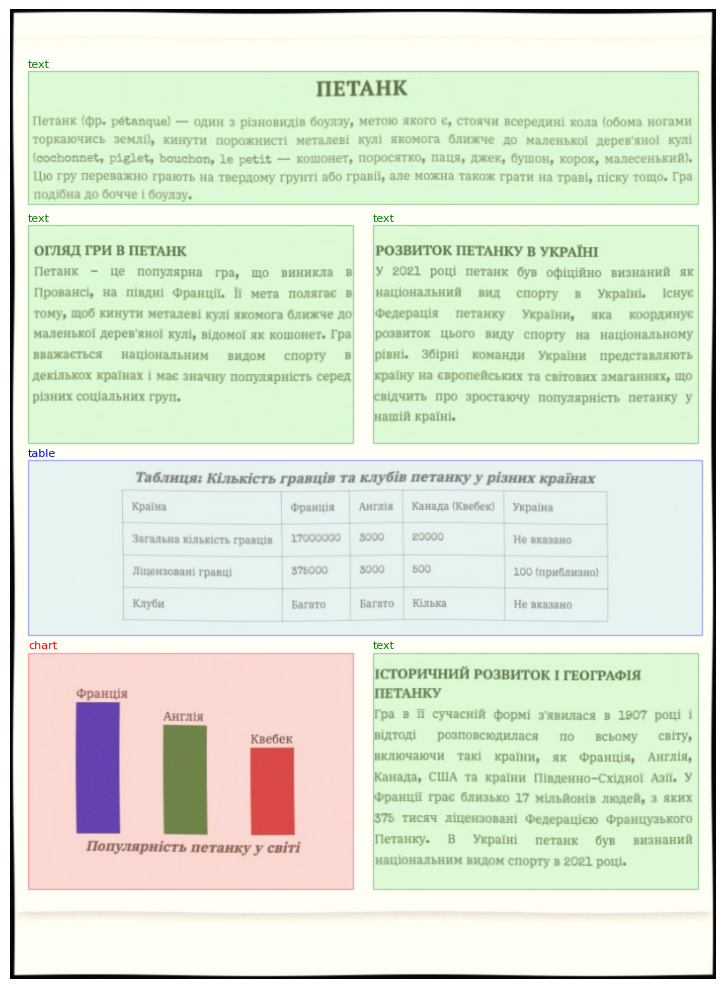

In [9]:
dv.visualize_grounding(example[0].get("image"), example[0]["grounding"])

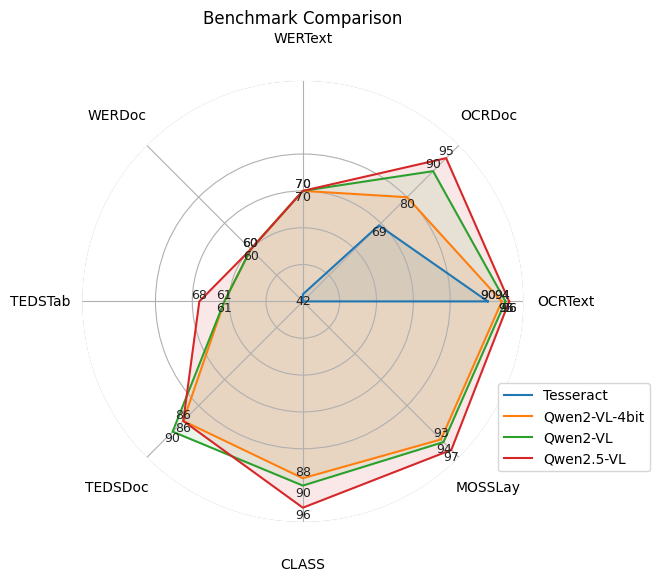

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and data
labels = ['OCRText', 'OCRDoc', 'WERText', 'WERDoc', 'TEDSTab', 'TEDSDoc', 'CLASS',
          'MOSSLay']

stats_cls_orc = [100-9.81, 100-30.82, 100-58.07, 40, 40, 40, 40, 40]
stats_qwen2_4bit = [100-6, 100-20, 100-30, 100-40, 61.3, 85.9, 88, 93]
stats_qwen2 = [100-5, 100-10, 100-30, 100-40, 61.3, 90, 90, 94]
stats_qwen2_5 = [100-4, 100-5, 100-30, 100-40, 68.1, 85.9, 96, 97]

# Angles
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Close the loop
stats_cls_orc += stats_cls_orc[:1]
stats_qwen2_4bit += stats_qwen2_4bit[:1]
stats_qwen2 += stats_qwen2[:1]
stats_qwen2_5 += stats_qwen2_5[:1]


# Plot
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# Plot lines and fills
ax.plot(angles, stats_cls_orc, label='Tesseract')
ax.plot(angles, stats_qwen2_4bit, label='Qwen2-VL-4bit')
ax.plot(angles, stats_qwen2, label='Qwen2-VL')
ax.plot(angles, stats_qwen2_5, label='Qwen2.5-VL')

ax.fill(angles, stats_cls_orc, alpha=0.1)
ax.fill(angles, stats_qwen2_4bit, alpha=0.1)
ax.fill(angles, stats_qwen2, alpha=0.1)
ax.fill(angles, stats_qwen2_5, alpha=0.1)

# Set labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

def add_labels1(angles, values):
    for angle, val in zip(angles, values):
        if val == 40:
            continue

        # Compute directional offset
        offset_r = 0.1
        dx = offset_r * np.cos(angle)
        dy = offset_r * np.sin(angle)

        ha = 'center' if np.cos(angle) > 0 else 'center'
        va = 'bottom' if np.sin(angle) > 0 else 'top'

        ax.text(angle, val + offset_r, f"{val:.0f}",
                ha=ha, va=va,
                fontsize=9, color="#222222",
                transform=ax.transData)
        
def add_labels2(angles, values):
    for angle, val in zip(angles, values):
        if val == 40:
            continue

        # Compute directional offset
        offset_r = 0.05
        dx = offset_r * np.cos(angle)
        dy = offset_r * np.sin(angle)

        ha = 'center' if np.cos(angle) > 0 else 'center'
        va = 'top' if np.sin(angle) > 0 else 'bottom'

        ax.text(angle, val + offset_r, f"{val:.0f}",
                ha=ha, va=va,
                fontsize=9, color="#222222",
                transform=ax.transData)
        
add_labels2(angles, stats_cls_orc)
add_labels1(angles, stats_qwen2)
add_labels2(angles, stats_qwen2_4bit)
add_labels1(angles, stats_qwen2_5)

# Remove outer circular boundary
ax.spines['polar'].set_edgecolor('none')
ax.spines['polar'].set_color('white')

gridlines = [line for line in ax.yaxis.get_gridlines()]
gridlines[4].set_color('none')
ax.set_yticklabels([])

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')  # optional: center-align
    label.set_verticalalignment('center')
    label.set_position((label.get_position()[0],-0.1))

ax.set_ylim(40, 100)
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.1))
plt.title("Benchmark Comparison")
plt.tight_layout()
plt.show()


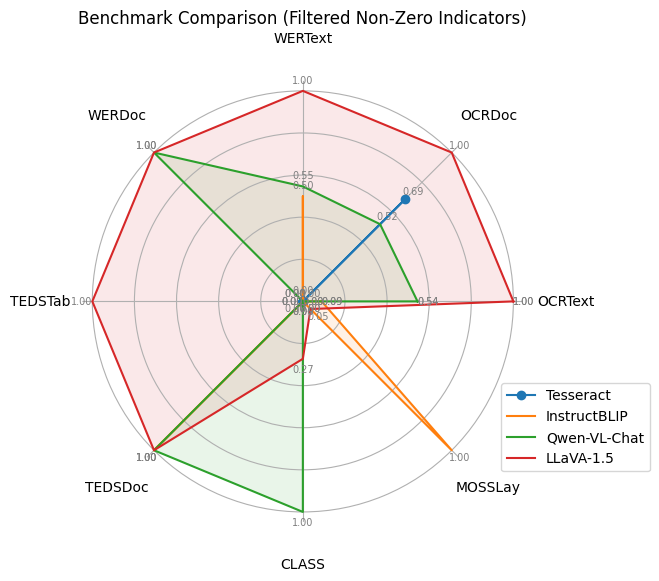

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and data
labels = ['OCRText', 'OCRDoc', 'WERText', 'WERDoc', 'TEDSTab', 'TEDSDoc', 'CLASS', 'MOSSLay']

stats_cls_orc = [100-9.81, 100-30.82, 100-58.07, 0, 0, 0, 0, 0]
stats_instructblip = [100, 45.3, 52.6, 61.2, 61.3, 85.9, 123.8, 187.5]
stats_qwen = [150, 63.3, 53.6, 68.2, 61.3, 85.9, 151.3, 60.6]
stats_llava = [200, 80.0, 63.3, 68.2, 68.1, 85.9, 131.3, 67.1]

# Combine and transpose to normalize per indicator
all_data = np.array([
    stats_cls_orc,
    stats_instructblip,
    stats_qwen,
    stats_llava
])
all_data_T = all_data.T

# Normalize each indicator (column) independently
normalized_data_T = []
for column in all_data_T:
    nonzero = column[column > 0]
    if len(nonzero) == 0:
        normalized = np.zeros_like(column)
    else:
        min_val = nonzero.min()
        max_val = nonzero.max()
        if max_val == min_val:
            normalized = np.ones_like(column)
        else:
            normalized = (column - min_val) / (max_val - min_val)
        normalized[column == 0] = 0  # keep zeros as zeros
    normalized_data_T.append(normalized)

# Transpose back to original shape
normalized_data = np.array(normalized_data_T).T

# Add closing points
scaled_cls_orc = normalized_data[0].tolist() + [normalized_data[0][0]]
scaled_instructblip = normalized_data[1].tolist() + [normalized_data[1][0]]
scaled_qwen = normalized_data[2].tolist() + [normalized_data[2][0]]
scaled_llava = normalized_data[3].tolist() + [normalized_data[3][0]]

# Angles
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# Plot lines and fills
ax.plot(angles, scaled_cls_orc, label='Tesseract', marker='o')
ax.plot(angles, scaled_instructblip, label='InstructBLIP')
ax.plot(angles, scaled_qwen, label='Qwen-VL-Chat')
ax.plot(angles, scaled_llava, label='LLaVA-1.5')

ax.fill(angles, scaled_cls_orc, alpha=0.1)
ax.fill(angles, scaled_instructblip, alpha=0.1)
ax.fill(angles, scaled_qwen, alpha=0.1)
ax.fill(angles, scaled_llava, alpha=0.1)

# Set angular labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Add text labels to each point
def add_labels(angles, values, color):
    for angle, val in zip(angles, values):
        ax.text(angle, val + 0.05, f"{val:.2f}", ha='center', va='center',
                fontsize=7, color=color)

add_labels(angles, scaled_cls_orc, 'tab:grey')
add_labels(angles, scaled_instructblip, 'tab:grey')
add_labels(angles, scaled_qwen, 'tab:grey')
add_labels(angles, scaled_llava, 'tab:grey')

# Remove outer circular boundary
ax.spines['polar'].set_edgecolor('none')
ax.spines['polar'].set_color('white')

# Hide outermost gridline
gridlines = [line for line in ax.yaxis.get_gridlines()]
if len(gridlines) > 0:
    gridlines[-1].set_color('none')

ax.set_yticklabels([])

# Move label positions outward
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')
    label.set_position((label.get_position()[0], -0.1))

plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.1))
plt.title("Benchmark Comparison (Filtered Non-Zero Indicators)")
plt.tight_layout()
plt.show()
